# Shopify Data challenge
By: Vy Khanh Pham 

# Part 1 

## Problem

On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis. 

1. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 
2. What metric would you report for this dataset?
3. What is its value?

## Short Answer: 

The AOV was originally calculated by averaging the `order_amount` which resulted in a big number like $3145. This is because **mean is sensitive to outliers** and it is not a robust measure of central tendency. So... what do we do?

Here are three possible solutions/approaches: 
1. I would recommend to use the **median**, which is a more robust measure of central tendency as it is not sensitive to outliers. 

2. **Log transformation** can also be used to transform skewed data to approximately conform to normality. We can use log to transform the data, find its average, and use log inverse to get it in the original units.

3. Another solution is to **remove outliers**, although this might not be the best approach. Read below for more explanations!

Values based on approaches: 
1. Median approach: $\$284$ **(This is the metric I would report.)**

2. Log transformation approach (Mean): $\$285.02$ 

3. Removing outliers approach (Mean):  $\$293.72$

## Work and Further Explanation

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib as plt
import warnings
warnings.filterwarnings('ignore')
shoe_store_data_dir = "ShopifyShoeDataset.csv"

In [3]:
shoe_store_df = pd.read_csv(shoe_store_data_dir)

### Part A 

**Question:** Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 

**Explanation**: From `describe()` we can see that the AOV or mean is $\$3,145.13$. However, we see that we have a huuggeee standard deviation and a large max value relative to our 75th percentile. Upon plotting the box plot (used log transformation for better visualization) and scatterplot (remove outlier for better visualization)  we can verify that the outliers are influencing our results. How? We are using the **mean** which is highly sensitive to outliers. 

Looking closer at the data, we see that the $\$704,000$ refers to a large order of 2000 coming from the same user and shop with an average value of  $\$352$. This appears to be a buyer that's perhaps purchasing wholesale for their own business, which is not the typically behavior of an average buyer. 

**Work**: 

In [4]:
shoe_store_df.order_amount.describe()

count      5000.000000
mean       3145.128000
std       41282.539349
min          90.000000
25%         163.000000
50%         284.000000
75%         390.000000
max      704000.000000
Name: order_amount, dtype: float64

Since are outliers are huge, I decided to do a log transformation to better present the distribution of `order_amount`.

In [5]:
df_log = np.log(shoe_store_df[['order_amount']].rename(columns={'order_amount' : 'Log order Amount'}))

Text(0.5, 1.0, 'Distribution of Order Amount (Log)')

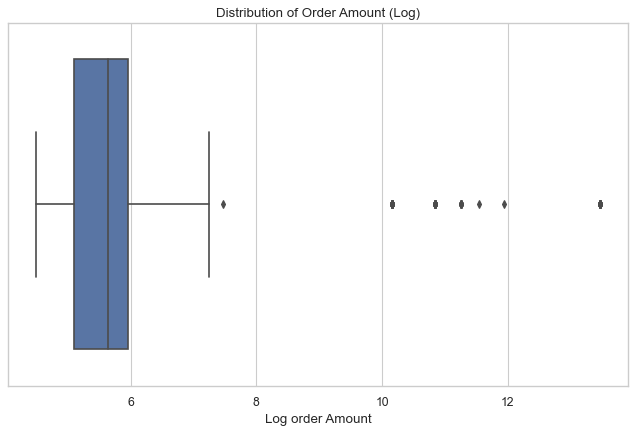

In [6]:
figure(figsize=(10, 6), dpi=80)
sns.set_theme(style="whitegrid")
sns.boxplot(x=df_log['Log order Amount']).set_title("Distribution of Order Amount (Log)")

Here is also another visulation that helps us understand the distribution. Below, I ploted total_items vs order_amount, excluding the extremely large order of 2,000 shoes. Interesting, we see some really high order amount even for relatively low number of items per order.  

Text(0.5, 1.0, 'Total Items vs Order Amount (Excluding orders with 2000 items)')

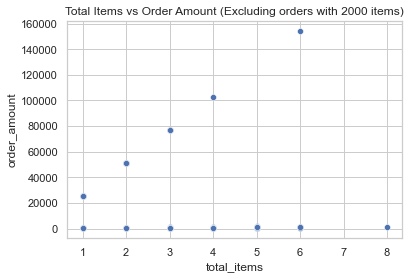

In [7]:
(sns.scatterplot(data = shoe_store_df[shoe_store_df['total_items'] != 2000], 
                 x= "total_items", 
                 y="order_amount").set_title("Total Items vs Order Amount (Excluding orders with 2000 items)")
)

Let's look at our outliers. It appears to be bulk orders. 

In [8]:
shoe_store_df.sort_values('order_amount', ascending=False).head(4)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
2153,2154,42,607,704000,2000,credit_card,2017-03-12 4:00:00
3332,3333,42,607,704000,2000,credit_card,2017-03-24 4:00:00
520,521,42,607,704000,2000,credit_card,2017-03-02 4:00:00
1602,1603,42,607,704000,2000,credit_card,2017-03-17 4:00:00


In [9]:
704000 / 2000 # Average value per shoe 

352.0

### Part B and C:  Approach and Values

### Approach 1: Finding the median

The mean is not a robust statistics because it is highly sensitive to outliers and non-normal distributions. This mean that extremely large values can "drag" the mean up and extremely low values can "drag" the mean down. 
The median on the other hand is a robust statistic as it is not sensitive to outliers. 

In [10]:
np.median(shoe_store_df['order_amount'])

284.0

### Approach 2: Log Transformation

There are many other transformations out there but log transformation is often used to transform skewed data to approximately conform to normality. With this in mind, I will find the average log order amount and then transform it back to the original units using exponential. 

In [11]:
log_avg = np.mean(np.log(shoe_store_df['order_amount'])) # Log transformation and then average
np.exp(log_avg) #Transform back to normal!

285.0204747254945

### Approach 3: Removing Outliers 

**Explanation**: 

Although this is a plausible approach to dealing with outliers in calculating AOV, there are many isssues with this. 
1. If the outlier data are legitamite samples, they can be informative and can provide other insights. 
2. With a small dataset, removing outliers can significantly change the outcome. Deleting them could bias our result significantly. 
3. High computational cost when we're dealing with a larger dataset or may not be feasible when dealing with real-time data. 

To exclude the outliers, I calculated Quartile 1 (25th percentile) and Quartile 2 (75th percentile). Then I calculated the IQR (Interquartile range). I calculated the lower and upper fences of $[-177.5, 730.5]$. This means that any data that lies outside of this range is considered to be an outlier. 

After removing the outliers, we received the AOV of **$\$293.71$** with 141 outliers dropped. using `describe()` for `order_amount` with no outliers, we now have a standard deviation of around **$\$144.45$**. 

**Work**:

In [12]:
df = shoe_store_df['order_amount']

In [13]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

(-177.5, 730.5)

In [14]:
df_without_outliers = df[df.between(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)]
np.mean(df_without_outliers)

293.7153735336489

From this approach, we ended up dropping 141 data points. 

In [15]:
len(df) - len(df_without_outliers)

141

In [16]:
df_without_outliers.describe()

count    4859.000000
mean      293.715374
std       144.453395
min        90.000000
25%       162.000000
50%       280.000000
75%       380.000000
max       730.000000
Name: order_amount, dtype: float64

# Part 2

### **Question 1** : How many orders were shipped by Speedy Express in total?

**Solution** : 54

`
    SELECT COUNT(DISTINCT OrderID) AS speedy_shipped
    FROM Orders
    JOIN Shippers 
    ON Orders.ShipperID = Shippers.ShipperID
    WHERE Shippers.ShipperName = "Speedy Express";
`

**Explanation**:
To find how many orders were shipped by Speedy Express, I: 
1. Joined the Orders and Shippers table on ShipperID 
2. Use COUNT and DISTINCT to find the unique orders that have been shipped
3. Then I used WHERE to find "Speedy Express" 

### **Question 2** : What is the last name of the employee with the most orders?

**Solution** : Peacock

` 
    SELECT a.LastName 
    FROM Employees as a, 
        (SELECT EmployeeID, 
            COUNT(*) as TotalOrder
            FROM Orders GROUP BY EmployeeID
            ORDER BY TotalOrder DESC LIMIT 1) as b 
    WHERE a.EmployeeID = b.EmployeeID;
`

**Explanation**: 
Let's break it down! 

In this part, I took the table TotalOrder and **grouped by** Employee ID. When grouping I used COUNT(\*) to count the total number of orders each employee made (Denoted as TotalOrder). Then, I **ordered** TotalOrder in descending order and used LIMIT 1 to isolate the employee with the highest amount of order. 

Let's denote this TABLE_A for the next part. 

`
    SELECT EmployeeID, 
    COUNT(*) as TotalOrder
    FROM Orders GROUP BY EmployeeID
    ORDER BY TotalOrder DESC LIMIT 1;
`
    

Then finally, I found the Employee's last name whose ID equals that ID of the only remaining Employee in TABLE_A.   

`
    SELECT a.LastName 
    FROM Employees as a, TABLE_A as b 
    WHERE a.EmployeeID = b.EmployeeID;
`

### **Question 3**: What product was ordered the most by customers in Germany?

**Solution**: Boston Crab Meat
 
`
        SELECT p.ProductName, SUM(od.Quantity) AS TotalUnitsSold
        FROM orderDetails as od 
        JOIN Orders as o 
            ON od.orderId=o.orderId
        JOIN Products p 
            ON od.productId = p.productId
        JOIN Customers c 
            ON o.customerId=c.customerId
        WHERE c.country='Germany'
        GROUP BY p.productId
        ORDER BY TotalUnitsSold DESC
        LIMIT 1; 
`

**Explanation**: 
In this question, I am interpreting that "ordered the most" means the products with the highest units sold. If the question referred to product that appears in the most orders, then I would simply change SUM(od.Quantity) to COUNT(od.Quantity). 

First, I joined orderdetails, orders, products, and customers. Then, I know that we need the customers to be from Germany, so I used WHERE c.country = 'Germany' to filter from there. Then, we need to figure out which product sold the most units so I used GROUP BY to group by the productID and SUM to sum up the amount of units sold while grouping. Then finally, I ordered SUM(od.Quantity) in Descending order and LIMIT 1 to isolate the product with the highest amount of units sold. 


